## Задание. Создать нейронную сеть со следующей структурой


Network( <br/> 
    (hidden): Linear(in_features=784, out_features=256, bias=True) <br/>
    (output): Linear(in_features=256, out_features=10, bias=True) <br/>
    (sigmoid): Sigmoid() <br/>
    (softmax): Softmax(dim=1) <br/>
)


Подключить необходимые библиотеки: torch, numpy и matplotlib.pyplot:

In [1]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.hidden = nn.Linear(784, 256)
        self.output = nn.Linear(256, 10)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.hidden(x)  
        x = self.sigmoid(x) 
        x = self.output(x)  
        x = self.softmax(x)  
        return x

model = Network()

print(model)

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


Создадим экземпляр класса и выведем его на печать, чтобы проверить, что наша архитектура совпадает с заданной:

In [6]:
print(model)

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


Будем использовать набор данных MNIST. Применим трансформации перевода в тензор и нормализации с параметрами (0.5):

In [2]:
from torchvision import datasets, transforms
import torch

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
    
# Download and load the training data
trainset = datasets.MNIST('./MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Зададим функцию view_classify для более удобного вывода результатов на экран:

In [9]:
def view_classify(img, ps, version="MNIST"):
    ''' 
    Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Будем итерироваться по тренировочному множеству и выведем результат работы нейронной сети на экран:

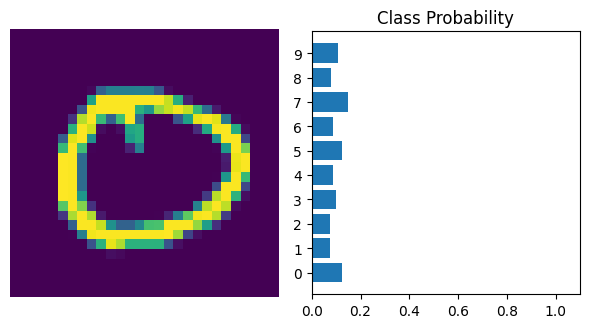

In [13]:
# Grab some data
## WRITE YOUR CODE HERE
images, labels = next(iter(trainloader))

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels)
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

Вопрос: почему получилось такое распределение вероятностей предсказаний классов?

Ответ: веса в этой нейронной сети задавались случайным образом, то есть сеть никак не обучалась.

## Обучение нейронной сети

Суть обучения нейронной сети заключается в подборе (посредством постепенного изменения) весов и bias-векторов (параметров сети) таким образом, чтобы разница между выходом нейронной сети и целевым значением была минимальна.

Для этого строится **функция потерь (Loss function)** - функция, которая оценивает <<расстояние>> между значением, которое получилось на выходе нейронной сети (Prediction), и заранее заданным значением (Labels).

Чтобы минимизировать функцию потерь, используется метод обратного распространения ошибки (Backpropagation), суть которого заключается в нахождении минимума функции потерь через вычисление её градиента, который в свою очередь зависит только от входных данных (поэтому обратное распространение). 

Метод обратного распространения ошибки включает в себя следующие шаги:
* Forward Pass (FP) — прямое распространение сигнала от входа к выходам (без которого не получить вычисленные значения в графе);
* Backward Pass (BP) — расчёт величины градиента от выхода ко входам;
* обновление весов в зависимости от величины градиента (скорость обучения или learning rate).

<img src="assets/forward_backward_pass.png" width='800'>

Существует несколько реализаций метода обратного распространения ошибки:
- стохастического градиентного спуска (Stochastic Gradient Descent, SGD);
- пакетного градиентного спуска (Mini-Bath Gradient Descent, MBGD).

Итого, один цикл обучения включает:
- загрузку данных (Features);
- один проход данных сквозь нейронную сеть (Neural Network);
- получение предсказаний нейронной сети (Prediction);
- выгрузка значений, которые соответствуют данным (Labels);
- построение функции потерь (Loss) от двух параметров Prediction и Loss;
- применение метода обратного распространения ошибки (Backpropagation).

<img src="assets/Training_cycle.png" width= "800">

Например, внутри одной эпохи обучения двухслойной неронной сети необходимо выполнять следующие действия:
- предобработать данные;
- умножить их на веса;
- применить функцию активации;
- снова умножить на веса;
- вычислить значение функции потерь;
- вычислить градиент функции потерь по весам;
- обновить веса;
- оценить точность.

Нейронная сеть в процессе **обучения** последовательно обрабатывает все объекты из обучающей выборки.
Предъявление нейронной сети всех объектов обучающей выборки по одному разу называется **эпохой обучения**.

Обучающую выборку разделяют на две части: непосредственно использующуюся для обучения (train data) и тестовую (test data) или валидационную (validation data). На тестовых данных каждую эпоху происходит оценка качества обучения. Стратегия разделения на train и test/validation подвыборки может быть произвольной, но при разделении следует заботиться о том, чтобы эти подвыборки были "похожи".

Обучение модели — итеративный процесс. На каждой итерции модель получает входные данные, дает предсказание на выходе, вычисляет значение функции потерь (loss), вычисляет производные функции потерь по параметрам и подстраивает параметры, используя градиентный спуск. Для более детального рассмотрения этого процесса рекомендуем посмотреть [видео об обратном распространении ошибки от 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

[Плейлист с видео о нейронных сетях от 3Blue1Brown с озвучкой на русском](https://www.youtube.com/playlist?list=PLfdZ2TeaMzfzlpZ60rbaYU_epH5XPNbWU).

## Гиперпараметры

Гиперпараметры — это задаваемые разработчиком параметры, которые позволяют управлять процессом обучения. Различные значения гиперпараметров могут влиять на обучение модели и скорость сходимости ([здесь](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) можно почитать подробнее про подбор гиперпараметров).

Определим следующие гиперпараметры процедуры обучения:
* **количество эпох** (`num_epochs`) — количество итераций обучения по всему набору данных;
* **размер батча** (`batch_size`) — количество образцов, передаваемых в сеть для обновления параметров;
* **скорость обучения** (`learning_rate`) — коэффициент, определяющий, насколько сильно нужно обновлять параметры модели на каждом батче. Малые значения приводят к долгому обучению, в то время как большие значения могут приводить к непредсказуемому поведению во время обучения.

In [14]:
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

## Функция потерь (Loss function)

При получении некоторых обучающих данных наша необученная сеть, скорее всего, не даст правильного ответа. Функция потерь измеряет степень различия между значениями на выходе сети и целевыми значениями. Именно функцию потерь мы и хотим минимизировать во время обучения. Для вычисления функции потерь нужно получить предсказание модели, передав ей на вход пример из данных, и сравнить его с истинным значением целевой переменной.

Наиболее часто применяемыми функциями потерь являются [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) для задач регрессии и [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) для задач класиификации.


Мы будем передавать выходы модели (логиты) в `nn.CrossEntropyLoss`, которая будет их нормализовывать и вычислять ошибку предсказания.

In [15]:
criterion = nn.CrossEntropyLoss()

## Оптимизатор (Optimizer)

Оптимизация — это процесс подстройки параметров модели для уменьшения ошибки на каждом шаге обучения. От **алгоритма оптимизации** зависит то, как этот процесс будет выполняться. Здесь мы будем использовать стохастический градиентный спуск (Stochastic Gradient Descent, SGD). Однако в PyTorch реализовано еще [множество других алгоритмов оптимизации](https://pytorch.org/docs/stable/optim.html#algorithms), таких как Adam и RMSProp, и они могут работать лучше или хуже для разных видов моделей и данных.

Вся логика оптимизации заключена в объекте `optimizer`. Мы инициализируем оптимизатор, передавая ему параметры модели, которые требуется обучать (`model.parameters()`), а также гиперпараметр скорости обучения (`learning_rate`).

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Цикл обучения

Внутри цикла обучения, оптимизация производится за три шага:
1. Вызов `optimizer.zero_grad()`, чтобы сбросить градиенты параметров модели. По умолчанию градиенты суммируются, и во избежание повторного вычисления их необходимо явно обнулять на каждой итерации;
2. Обратное распространение ошибки предсказания с помощью вызова `loss.backward()`. PyTorch вычислит градиенты функции потерь относительно каждого обучаемого параметра;
3. Когда у нас есть градиенты, мы вызываем `optimizer.step()`, чтобы подстроить обучаемые параметры с учетом градиентов, посчитанных при обратном распространении, согласно алгоритму оптимизации.

Итого, в цикле обучения в следующем порядке должны идти строчки:  <br>
optimizer.zero_grad() <br>
loss.backward()  <br>
optimizer.step()  <br>

Наиболее просто полный процесс обучения нейронной сети может быть представлен следующим кодом:

In [17]:
from torch import optim

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


num_epochs = 5
learning_rate = 0.003

criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for e in range(num_epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()    
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9521370701698353
Training loss: 0.8917966132987537
Training loss: 0.5364835292482173
Training loss: 0.4399409221052361
Training loss: 0.3947407068696612


Посмотрим на вероятности предсказанных классов после обучения нейронной сети:

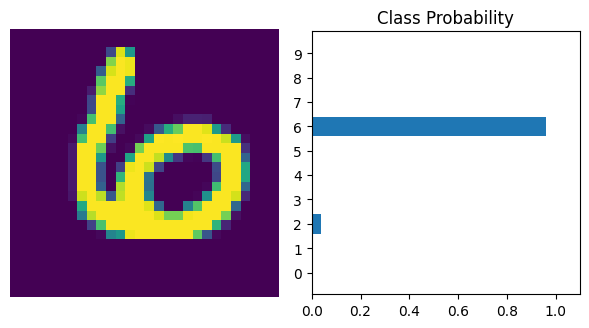

In [20]:
%matplotlib inline

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

Видим, что нейронная сеть уже научилась распознавать цифры с достаточно большой вероятностью.

# Пример нейронной сети для решения задачи классификации на наборе данных MNIST

Шаг 1. Подгружаем необходимые библиотеки:

In [3]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from IPython.display import clear_output
from torch.utils.data import DataLoader

Шаг 2. Выбираем гиперпараметры для нейронной сети:

In [4]:
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

Шаг 3. Загружаем набор данных MNIST:

In [5]:
train_data_MNIST = datasets.MNIST(
    root="./MNIST", train=True, download=True, transform=ToTensor()
)

test_data_MNIST = datasets.MNIST(
    root="./MNIST", train=False, download=True, transform=ToTensor()
)

Шаг 4. Посмотрим на основные параметры данных:

In [6]:
print("train_data.data:")
print("Type: ", type(train_data_MNIST.data))
print("Size: ", train_data_MNIST.data.size())
print("Dtype:", train_data_MNIST.data.dtype)
print("Max:  ", train_data_MNIST.data.max())
print("Min:  ", train_data_MNIST.data.min())

train_data.data:
Type:  <class 'torch.Tensor'>
Size:  torch.Size([60000, 28, 28])
Dtype: torch.uint8
Max:   tensor(255, dtype=torch.uint8)
Min:   tensor(0, dtype=torch.uint8)


Шаг 5. Посмотрим на матожидание и дисперсию:

In [7]:
mean = torch.mean(train_data_MNIST.data.float())
std = torch.std(train_data_MNIST.data.float())

print(f"mean = {mean:.2f}, std = {std:.2f}")

mean = 33.32, std = 78.57


Шаг 6. Нормализуем значения, чтобы они попали в диапазон $[0;1]$:

In [8]:
mean = torch.mean(train_data_MNIST.data.float()) / 255
std = torch.std(train_data_MNIST.data.float()) / 255

print(f"mean = {mean:.2f}, std = {std:.2f}")

mean = 0.13, std = 0.31


Шаг 7. Мы вычислили среднее и стандартное отклонение по обучающей выборке MNIST для применения транcформации Normalize. Но мы также помним, что она должна применяться только после ToTensor:

In [9]:
from torchvision import transforms

transform_with_normalize = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize(mean, std) 
])

print(transform_with_normalize)

Compose(
    ToTensor()
    Normalize(mean=0.13066047430038452, std=0.30810779333114624)
)


Шаг 8. Заменим тренировочные и тестовые данные на новые с применённой трансфоормацией: 

In [10]:
print("Old train transform:", train_data_MNIST.transform)
print("Old test transform:", test_data_MNIST.transform)

train_data_MNIST.transform = transform_with_normalize
test_data_MNIST.transform =  transform_with_normalize

print("\nNew train transform:", train_data_MNIST.transform)
print("New test transform:", test_data_MNIST.transform)

Old train transform: ToTensor()
Old test transform: ToTensor()

New train transform: Compose(
    ToTensor()
    Normalize(mean=0.13066047430038452, std=0.30810779333114624)
)
New test transform: Compose(
    ToTensor()
    Normalize(mean=0.13066047430038452, std=0.30810779333114624)
)


In [24]:
train_dataloader = DataLoader(train_data_MNIST, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_data_MNIST, batch_size=256, shuffle=False)

Шаг 9. Выбираем устройство для обучения:

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Шаг 10. Задаём архитектуру нейронной сети:

In [35]:
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)
        return x

Шаг 11. Создадим объект класса указанной нейронной сети и выведем его архитектуру:

In [36]:
model = NeuralNetwork()

model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

Шаг 12. Выберем функцию потерь и оптимизатор:

In [37]:
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.003)

Шаг 13. Зададим функции обучения на тренировочном и тестовом множествах:

In [29]:
def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Compute prediction and loss
        pred = model(imgs)
        loss = criterion(pred, labels)

        # Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss

def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Compute prediction and loss
            pred = model(imgs)
            loss = criterion(pred, labels)

            test_loss += loss.item()
            correct += (pred.argmax(1) == labels).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct
    print(f"Test loss: {test_loss:>8f}, test accuracy: {accuracy:>0.1f}% \n")

    return test_loss, accuracy


In [396]:
def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        # Compute prediction and loss
        pred = model(imgs.to(device))
        loss = ## WRITE YOUR CODE HERE

        # Optimization
        ## WRITE YOUR CODE HERE

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = ## WRITE YOUR CODE HERE
            loss = ## WRITE YOUR CODE HERE

            test_loss += loss.item()
            correct += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )

    test_loss /= num_batches
    correct /= size
    print(f"Test loss: {test_loss:>8f}, test accuracy: {(100*correct):>0.1f}% \n")

    return test_loss

Шаг 14. Запустим процесс обучения:

In [38]:
# for plotting
loss_history = {"train": [], "test": []}

for i in range(num_epochs):
    print(f"Epoch {i + 1}")
    
    # Тренировка и вычисление потерь на тренировочном множестве
    train_loss = train_loop(train_dataloader, model, loss, optim)
    
    # Тестирование и вычисление потерь на тестовом множестве
    test_loss, accuracy = test_loop(test_dataloader, model, loss)
    
    # Сохраняем историю потерь
    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)

print("Done!")

Epoch 1
Train loss: 0.233354
Test loss: 0.095657, test accuracy: 96.9% 

Epoch 2
Train loss: 0.089212
Test loss: 0.106172, test accuracy: 96.6% 

Epoch 3
Train loss: 0.063519
Test loss: 0.073829, test accuracy: 97.8% 

Epoch 4
Train loss: 0.048192
Test loss: 0.085426, test accuracy: 97.5% 

Epoch 5
Train loss: 0.040150
Test loss: 0.073328, test accuracy: 98.0% 

Epoch 6
Train loss: 0.034445
Test loss: 0.086865, test accuracy: 97.7% 

Epoch 7
Train loss: 0.032862
Test loss: 0.086658, test accuracy: 97.8% 

Epoch 8
Train loss: 0.023473
Test loss: 0.078401, test accuracy: 98.0% 

Epoch 9
Train loss: 0.023837
Test loss: 0.081754, test accuracy: 97.9% 

Epoch 10
Train loss: 0.027456
Test loss: 0.098005, test accuracy: 97.9% 

Done!


Шаг 15. Построим графики функции потерь на тренировочном и тестовом множествах:

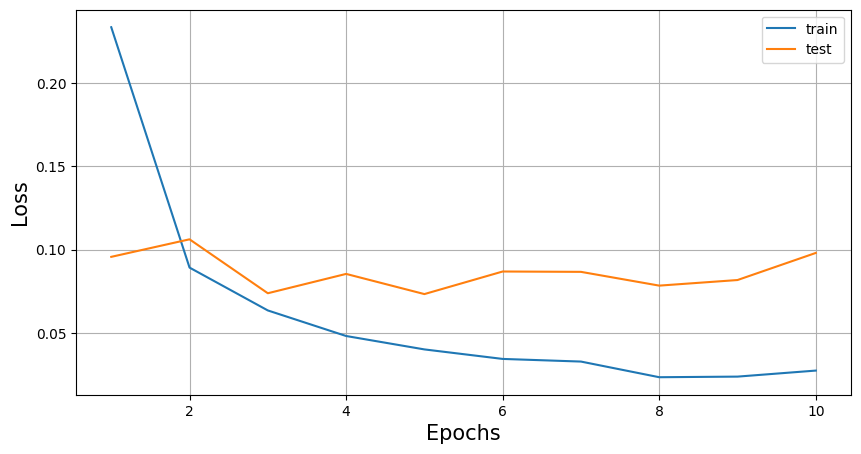

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid()
plt.show()

## Обработка результатов:

Поэтапно пропустим тестовые изображения через модель и посмотрим на размерности:

In [55]:
# get batch
imgs, labels = next(iter(test_dataloader))
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([256, 1, 28, 28])


In [56]:
# get output
pred = model(imgs.to(device))
print("pred shape: ", pred.shape)

pred shape:  torch.Size([256, 10])


Посмотрим на результаты обработки нейронной сети для выбранного батча:

In [57]:
# First sample in prediction batch
pred[0]

tensor([ -8.8422,   0.3582,  -4.1478,   1.4328,  -5.0729,  -9.4295, -12.9970,
         16.2465,  -7.8813,   2.1012], device='cuda:0',
       grad_fn=<SelectBackward0>)

Чтобы посчитать вероятность, применим функццию softmax:

In [58]:
# Calculate probabilities
nn.Softmax(dim=0)(pred[0].detach())

tensor([1.2708e-11, 1.2583e-07, 1.3895e-09, 3.6854e-07, 5.5090e-10, 7.0638e-12,
        1.9938e-13, 1.0000e+00, 3.3220e-11, 7.1902e-07], device='cuda:0')

Изменим размерности данных для вывода картинок на экран:

In [59]:
# remove axis
imgs = torch.reshape(imgs, (256, 28, 28))
print("imgs shape(after reshape): ", imgs.shape)

imgs shape(after reshape):  torch.Size([256, 28, 28])


In [60]:
# take 10 first images
imgs = imgs[:10]
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([10, 28, 28])


Посмотрим на предсказанные вероятности и выведем позицию максимального значения:

In [61]:
import numpy as np

pred = pred[:10].detach()
print("Prediction(1 sample):\n", pred[0])
digits = np.argmax(pred.cpu().numpy(), axis=1)
print("Predicted class: ", digits[0])

Prediction(1 sample):
 tensor([ -8.8422,   0.3582,  -4.1478,   1.4328,  -5.0729,  -9.4295, -12.9970,
         16.2465,  -7.8813,   2.1012], device='cuda:0')
Predicted class:  7


Визуализируем изображения, подпишем предсказанное и истинное значение:

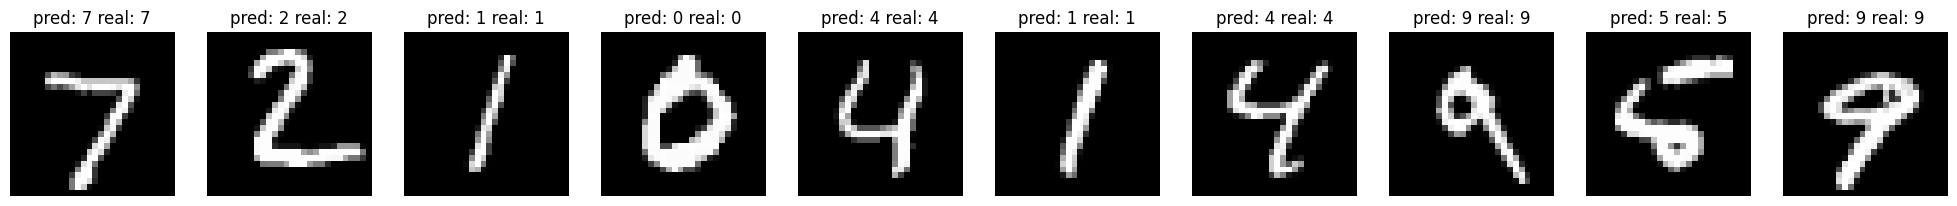

In [62]:
plt.figure(figsize=(25.0, 25.0))
for i in range(10):
    img = imgs[i]

    plt.subplot(1, 10, i + 1)
    plt.title(
        "pred: " + str(digits[i]) + " real: " + str(labels[i].numpy())
    )  # predicted and real values
    plt.axis("off")
    plt.imshow(img.numpy(), cmap="gray")

## Сохранение и загрузка весов модели

Обычно обучение модели является достаточно затратным процессом с точки зрения вычислительных ресурсов. Поэтому, однажды обучив сеть, разумно будет сохранить ее для последующего использования. Рассмотрим варианты, как это можно сделать в PyTorch.

Модели PyTorch хранят обучаемые параметры во внутреннем словаре состояния, который называется `state_dict`. Их можно сохранить с помощью метода `torch.save`.


In [63]:
torch.save(model.state_dict(), "model_weights.pth")

Для того, чтобы загрузить веса модели, сперва необходимо создать экземпляр такой модели, а затем загрузить параметры с помощью метода `load_state_dict()`.

In [67]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model_weights.pth"))
model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [68]:
imgs, labels = next(iter(test_dataloader))
pred = model(torch.reshape(imgs, (256, 28, 28)).to(device))

In [69]:
pred = pred.detach()
print("Prediction(1 sample):\n", pred)
digits = np.argmax(pred.cpu().numpy(), axis=1)
print(digits)

Prediction(1 sample):
 tensor([[ -8.8422,   0.3582,  -4.1478,  ...,  16.2465,  -7.8813,   2.1012],
        [ -6.7898,  -1.7082,  25.3615,  ..., -15.9372,  -0.6459, -13.0732],
        [-10.4180,  15.1604,  -9.4118,  ...,  -5.7116,   0.3360,  -1.9835],
        ...,
        [-13.9207, -16.5031, -12.8986,  ..., -17.9277,  -3.0325,   5.9829],
        [ -7.4261,  -0.8288,  -0.7441,  ...,  16.5022,  -8.2789,   3.0645],
        [ -9.4313,   1.8045,   8.3075,  ...,  13.4585,  -5.6533,  -0.4591]],
       device='cuda:0')
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 2 9 7 7 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 7 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 4 4 4 9 2 5 4 7 6 7 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 9 3 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 2 3 2 9 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 9 0 3 1 6 4 2 3 6 1 1 1 3 9 5 2 9 4 5 9 3 9 0 3 5 5 5 7 2
 2 7 1 2 8 4 1 7 3 3 8 8 7 9 2 2 